## Utilizing FIFA (2022 & 2018) Tweets as a source of gaining insights to facilitate betting practices

### Developed by Stavros Stavrou

### Introduction - Objectives

The FIFA World Cup (or simply World Cup) is held every four years. Teams that have qualified (through previous years’ qualification phase), compete for the title at venues within the host nation(s) for about a month. Within this month, teams (countries) progress (or not) through Group Stage (32), Round of 16, Quarter Finals (8), Semi Finals (4) to reach the Final and claim the trophy.

In the coded artifacts that follow, we will perform an analysis of FIFA World Cup related tweets for the years 2018 and 2022 and through them try to discover and reveal the public sentiment of the predicted Winner of the World Cup as it evolves in time from the start of the WC to the Semi Finals. The datasets are available at: https://www.kaggle.com/rgupta09/world-cup-2018-tweets & https://www.kaggle.com/datasets/konradb/qatar-world-cup-2022-tweets
The results will be then examined and cross-referenced to winning odds probabilities (as given by Bookmakers), as they too change over the respective time period, in an attempt to identify any patterns and correlation between the two. 

In order to achieve this, only the four teams (countries) that reached the Semi Finals for each respective World Cup (2018 & 2022) were studied, as other teams were ‘eliminated’ at prior stages (and thus do not exist within the entire time framework examined).


### Execution Framework (flow/steps)

This jupyter execution notebook:
1.	Sets the environment to connect with Google Cloud (Project-Bucket-Cluster) and exploit the resources of GC (submitting a job to the google cloud cluster enabled via Dataproc).
2.	Points to the directories of files to be used during the execution of the code. These include the 2 fifa tweet datasets and a .py file (code explained) 
3.	Establishes a connection with Google Cloud wηere the code (.py file) will be executed. 
4.	The .py file code:<br>
    a.	 Creates the Spark Context (pyspark is utilized for parallelized and in-memory processing)<br>
    b.	 Initially reads the csv datasets as pandas dataframe, gives it a schema and then creates a spark dataframe of tweets that will optimize the execution plan on the queries (datapoints are now organized under named columns).<br>
    c.	 Defines the various functions for tweet text pre-processing, filtering by date and keywords in tweet text, counting and returning a combined and defined dataframe of results and calculations.<br> 
    d.	 The next step sets the variables by which the queries are performed. These include various keywords that in case of co-existence in a tweet text are thought to reveal user’s sentiment towards the winning team/country of the WC. The results are then exported to a csv file.<br> 
    e.	 The same procedure (§d) is applied for both fifa tweet datasets, but keywords dates and countries are customized to each WC. The need to stop and re-initialize the SparkContext is noted.<br>
5.	Finally, the outputted files (one for each fifa WC tweet dataset) are explored alongside with data (files) that contain respective bookmakers’ probability odds obtained (manually) and recorded. Insights can be gained through graphs or other visualizations.<br> 


### Code

In [ ]:
!pip install fsspec
!pip install gcsfs
!pip install pandas
!pip install matplotlib
!pip install --upgrade google-cloud-dataproc

In [2]:
import os 
import subprocess
import pandas as pd 
import matplotlib.pyplot as plt


# Set the global variables for the submit command to work
os.environ['PROJECT']="daring-pier-375119"
os.environ['BUCKET_NAME']="dataproc-temp-us-central1-52380985107-w0nwlljl"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "./daring-pier-375119-52ad87c38fe4.json"
os.environ['CLUSTER'] = "cluster-pyspark"
os.environ['REGION'] = "us-central1"

In [3]:
# Set necessary variables to be given to the google cloud command
PROJECT ="daring-pier-375119" # project's name
BUCKET_NAME="dataproc-temp-us-central1-52380985107-w0nwlljl" # google bucket name
# file with the authentication credentials
GOOGLE_APPLICATION_CREDENTIALS = "./daring-pier-375119-52ad87c38fe4.json" 
CLUSTER = "cluster-pyspark" # cluster name
REGION = "us-central1" # cluster region

In [4]:
# Set the csvs and python files directories
fifa22 = f"gs://{BUCKET_NAME}/FIFA2022.csv"
fifa18 = f"gs://{BUCKET_NAME}/FIFA2018.csv"
py_file = f"gs://{BUCKET_NAME}/Final_Project.py"

In [5]:
from google.cloud import dataproc_v1 as dataproc
from google.oauth2 import service_account

# initialize the google credetinals using the json file
credentials = service_account.Credentials.from_service_account_file(GOOGLE_APPLICATION_CREDENTIALS)

os.environ["GOOGLE_API_USE_CLIENT_CERTIFICATE "] ="True"
# Create a job controller client, adjusting the endpoint
client = dataproc.JobControllerClient(credentials=credentials,
    client_options={"api_endpoint": f"{REGION}-dataproc.googleapis.com:443"})

# Create the job request
# Initialize request argument(s)
job = dataproc.Job()
job.pyspark_job.main_python_file_uri = py_file
job.placement.cluster_name = CLUSTER
job.pyspark_job.args = [ fifa22,fifa18, f"gs://{BUCKET_NAME}/output/"]


request = dataproc.SubmitJobRequest(
    project_id=PROJECT,
    region=REGION,
    job=job,
)

# Make the request
response = client.submit_job(request=request)

# Initialize request argument(s) to get the status of the job
request2 = dataproc.GetJobRequest(
    project_id=PROJECT,
    region=REGION,
    job_id=response.reference.job_id,
)


# wait until job is done
response2 = client.get_job(request=request2)
print('Job Submitted.\nWaiting for the job to be completed ...')
while ( response2.status.state != 5 ): # sometimes it takes longer for the response status to change
    response2 = client.get_job(request=request2)
# Handle the response
print(response2)


Job Submitted.
Waiting for the job to be completed ...
reference {
  project_id: "daring-pier-375119"
  job_id: "f2505e26-b1d5-427b-85a6-ae7479527314"
}
placement {
  cluster_name: "cluster-pyspark"
  cluster_uuid: "5aadae31-9328-4059-8790-d7b0018ebcd3"
}
pyspark_job {
  main_python_file_uri: "gs://dataproc-temp-us-central1-52380985107-w0nwlljl/Final_Project.py"
  args: "gs://dataproc-temp-us-central1-52380985107-w0nwlljl/FIFA2022.csv"
  args: "gs://dataproc-temp-us-central1-52380985107-w0nwlljl/FIFA2018.csv"
  args: "gs://dataproc-temp-us-central1-52380985107-w0nwlljl/output/"
}
status {
  state: DONE
  state_start_time {
    seconds: 1674308141
    nanos: 746061000
  }
}
status_history {
  state: PENDING
  state_start_time {
    seconds: 1674308058
    nanos: 602254000
  }
}
status_history {
  state: SETUP_DONE
  state_start_time {
    seconds: 1674308058
    nanos: 656493000
  }
}
status_history {
  state: RUNNING
  details: "Agent reported job success"
  state_start_time {
    seco

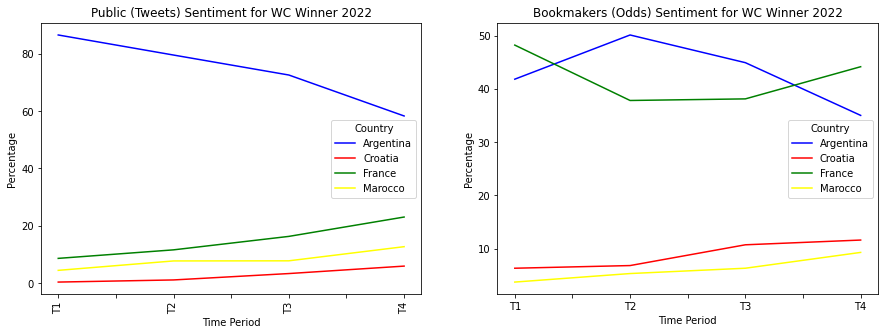

In [14]:
# Read the csv file
df = pd.read_csv(f"gs://{BUCKET_NAME}/output/results_2022.csv", index_col=0)
# Create a dictionary of the dates to replace
replace_dict = {'11/20/2022': 'T1', '12/02/2022': 'T2', '12/07/2022': 'T3', '12/11/2022': 'T4'}
# Replace the dates in the Start_Date column with the new values
df['Start Date'] = df['Start Date'].replace(replace_dict)
# Set the X axis to the 'Start_Date' column
df.set_index('Start Date', inplace=True)
# Reshape the dataframe to have 'Country' as columns
df_pivot = df.pivot(columns='Country', values='Percentage')

# Read the csv file
df2 = pd.read_csv(f"probabilities_2022.csv", index_col=0)
df2.set_index('Start Date', inplace=True)
# Reshape the dataframe to have 'Country' as columns
df_pivot2 = df2.pivot(columns='Country', values='Percentage')

colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
df_pivot.plot(kind='line',ax=ax1,rot=90)
ax1.set_title('Public (Tweets) Sentiment for WC Winner 2022')
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Percentage')

df_pivot2.plot(kind='line',ax=ax2)
ax2.set_title('Bookmakers (Odds) Sentiment for WC Winner 2022')
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Percentage')

# Show the graph
plt.show()



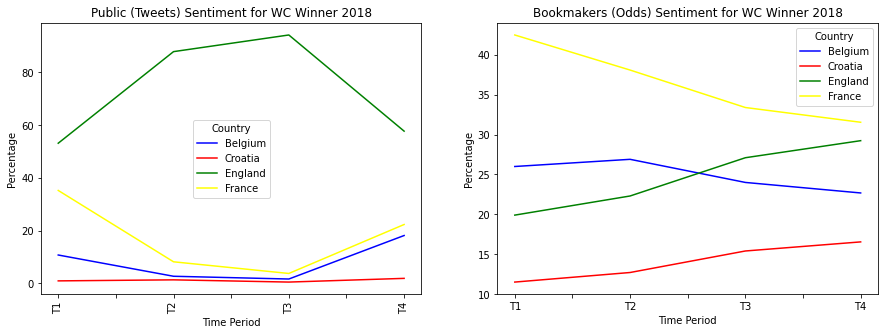

In [7]:
# Read the csv file
df = pd.read_csv(f"gs://{BUCKET_NAME}/output/results_2018.csv", index_col=0)
replace_dict = {'06/29/2018': 'T1', '07/01/2018': 'T2', '07/02/2018': 'T3', '07/10/2018': 'T4'}
# Replace the dates in the Start_Date column with the new values
df['Start Date'] = df['Start Date'].replace(replace_dict)
# Set the X axis to the 'Start_Date' column
df.set_index('Start Date', inplace=True)
# Reshape the dataframe to have 'Country' as columns
df_pivot = df.pivot(columns='Country', values='Percentage')

# Read the csv file
df2 = pd.read_csv(f"probabilities_2018.csv", index_col=0)
df2.set_index('Start Date', inplace=True)
# Reshape the dataframe to have 'Country' as columns
df_pivot2 = df2.pivot(columns='Country', values='Percentage')

colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
df_pivot.plot(kind='line',ax=ax1,rot=90)
ax1.set_title('Public (Tweets) Sentiment for WC Winner 2018')
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Percentage')

df_pivot2.plot(kind='line',ax=ax2)
ax2.set_title('Bookmakers (Odds) Sentiment for WC Winner 2018')
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Percentage')

# Show the graph
plt.show()



In [8]:
### Backup if Google Clound is not working
import os
stream = os.popen(f"python ./Final_Project.py FIFA2022.csv FIFA2018.csv output"	)
output = stream.read()
# wait for it to finish for 1-2 minutes (it will create files)

In [9]:
print(output)

23/01/21 15:36:23 WARN TaskSetManager: Stage 0 contains a task of very large size (9649 KiB). The maximum recommended task size is 1000 KiB.
23/01/21 15:36:25 WARN ProcfsMetricsGetter: Exception when trying to compute pagesize, as a result reporting of ProcessTree metrics is stopped
23/01/21 15:36:33 WARN TaskSetManager: Stage 1 contains a task of very large size (9649 KiB). The maximum recommended task size is 1000 KiB.
23/01/21 15:36:45 WARN TaskSetManager: Stage 31 contains a task of very large size (9649 KiB). The maximum recommended task size is 1000 KiB.
23/01/21 15:36:51 WARN TaskSetManager: Stage 32 contains a task of very large size (9649 KiB). The maximum recommended task size is 1000 KiB.
23/01/21 15:36:59 WARN TaskSetManager: Stage 62 contains a task of very large size (9649 KiB). The maximum recommended task size is 1000 KiB.
23/01/21 15:37:05 WARN TaskSetManager: Stage 63 contains a task of very large size (9649 KiB). The maximum recommended task size is 1000 KiB.
23/01/2

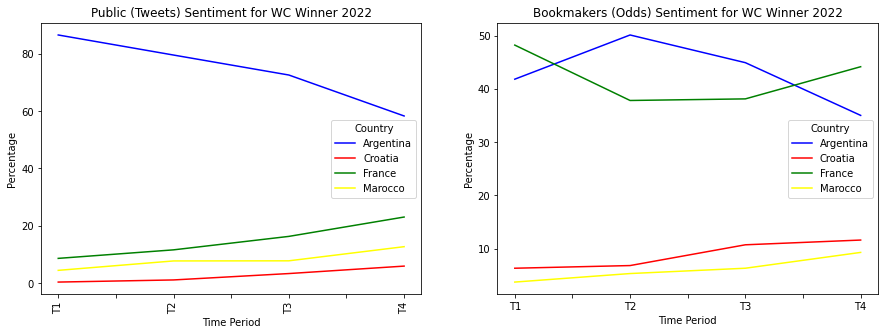

In [12]:
# Read the csv file
df = pd.read_csv(f"./output/results_2022.csv", index_col=0)
replace_dict = {'11/20/2022': 'T1', '12/02/2022': 'T2', '12/07/2022': 'T3', '12/11/2022': 'T4'}
# Replace the dates in the Start_Date column with the new values
df['Start Date'] = df['Start Date'].replace(replace_dict)
# Set the X axis to the 'Start_Date' column
df.set_index('Start Date', inplace=True)
# Reshape the dataframe to have 'Country' as columns
df_pivot = df.pivot(columns='Country', values='Percentage')

# Read the csv file
df2 = pd.read_csv(f"probabilities_2022.csv", index_col=0)
df2.set_index('Start Date', inplace=True)
# Reshape the dataframe to have 'Country' as columns
df_pivot2 = df2.pivot(columns='Country', values='Percentage')

colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
df_pivot.plot(kind='line',ax=ax1,rot=90)
ax1.set_title('Public (Tweets) Sentiment for WC Winner 2022')
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Percentage')

df_pivot2.plot(kind='line',ax=ax2)
ax2.set_title('Bookmakers (Odds) Sentiment for WC Winner 2022')
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Percentage')

# Show the graph
plt.show()


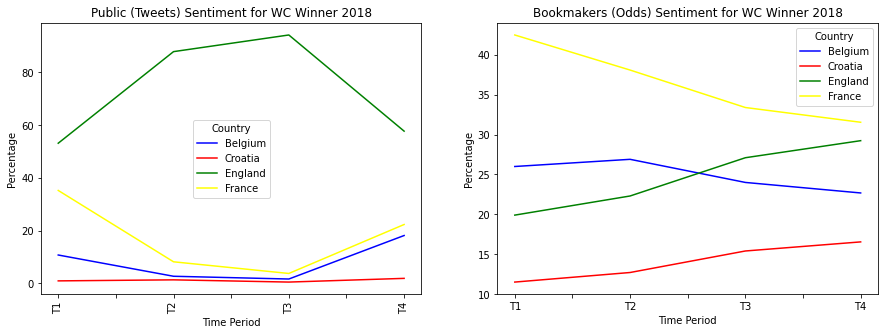

In [13]:
# Read the csv file
df = pd.read_csv(f"./output/results_2018.csv", index_col=0)
replace_dict = {'06/29/2018': 'T1', '07/01/2018': 'T2', '07/02/2018': 'T3', '07/10/2018': 'T4'}
# Replace the dates in the Start_Date column with the new values
df['Start Date'] = df['Start Date'].replace(replace_dict)
# Set the X axis to the 'Start_Date' column
df.set_index('Start Date', inplace=True)
# Reshape the dataframe to have 'Country' as columns
df_pivot = df.pivot(columns='Country', values='Percentage')

# Read the csv file
df2 = pd.read_csv(f"probabilities_2018.csv", index_col=0)
df2.set_index('Start Date', inplace=True)
# Reshape the dataframe to have 'Country' as columns
df_pivot2 = df2.pivot(columns='Country', values='Percentage')

colors = ['blue', 'red', 'green', 'yellow', 'purple', 'orange']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
df_pivot.plot(kind='line',ax=ax1,rot=90)
ax1.set_title('Public (Tweets) Sentiment for WC Winner 2018')
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Percentage')

df_pivot2.plot(kind='line',ax=ax2)
ax2.set_title('Bookmakers (Odds) Sentiment for WC Winner 2018')
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Percentage')

# Show the graph
plt.show()

